# Week 8 - Deep learning

In this homework, we'll build a model for predicting if we have an image of a bee or a wasp. 
For this, we will use the "Bee or Wasp?" dataset that was obtained from [Kaggle](https://www.kaggle.com/datasets/jerzydziewierz/bee-vs-wasp) and slightly rebuilt. 

You can download the dataset for this homework from [here](https://github.com/SVizor42/ML_Zoomcamp/releases/download/bee-wasp-data/data.zip):

```bash
wget https://github.com/SVizor42/ML_Zoomcamp/releases/download/bee-wasp-data/data.zip
unzip data.zip
```

In the lectures we saw how to use a pre-trained neural network. In the homework, we'll train a much smaller model from scratch. 

> **Note:** you will need an environment with a GPU for this homework. We recommend to use [Saturn Cloud](https://bit.ly/saturn-mlzoomcamp). 
> You can also use a computer without a GPU (e.g. your laptop), but it will be slower.


### Data Preparation

The dataset contains around 2500 images of bees and around 2100 images of wasps. 

The dataset contains separate folders for training and test sets. 

In [17]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
# from keras.applications.xception import Xception, preprocess_input, decode_predictions
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# !wget https://github.com/SVizor42/ML_Zoomcamp/releases/download/bee-wasp-data/data.zip
# !unzip data.zip

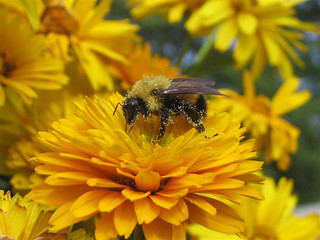

In [3]:
path = './data/train'
img_name = '/bee/2984293_b650d46745_n.jpg'
full_path = f'{path}/{img_name}'
load_img(full_path)

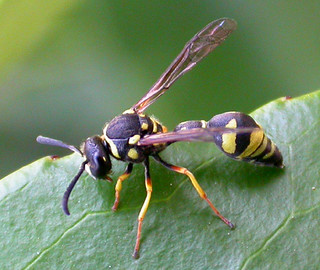

In [4]:
img_name = '/wasp/4516007_8134114ca5_n.jpg'
full_path = f'{path}/{img_name}'
load_img(full_path)

# Training a CNN model

### Model

For this homework we will use Convolutional Neural Network (CNN). Like in the lectures, we'll use Keras.

You need to develop the model with following structure:

* The shape for input should be `(150, 150, 3)`
* Next, create a convolutional layer ([`Conv2D`](https://keras.io/api/layers/convolution_layers/convolution2d/)):
    * Use 32 filters
    * Kernel size should be `(3, 3)` (that's the size of the filter)
    * Use `'relu'` as activation 
* Reduce the size of the feature map with max pooling ([`MaxPooling2D`](https://keras.io/api/layers/pooling_layers/max_pooling2d/))
    * Set the pooling size to `(2, 2)`
* Turn the multi-dimensional result into vectors using a [`Flatten`](https://keras.io/api/layers/reshaping_layers/flatten/) layer
* Next, add a `Dense` layer with 64 neurons and `'relu'` activation
* Finally, create the `Dense` layer with 1 neuron - this will be the output
    * The output layer should have an activation - use the appropriate activation for the binary classification case

As optimizer use [`SGD`](https://keras.io/api/optimizers/sgd/) with the following parameters:

* `SGD(lr=0.002, momentum=0.8)`

In [5]:
INPUT_SHAPE = (150, 150, 3)
FILTERS = 32
KERNEL_SIZE = (3,3)
POOL_SIZE = (2,2)
NUM_NEURONS = 64

base_model = Sequential([Conv2D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu'),
               MaxPool2D(pool_size=POOL_SIZE),
                Flatten(),
                Dense(NUM_NEURONS, activation='relu'),
                Dense(1, activation='sigmoid')])

sgd_optimizer = SGD(lr=0.002, momentum=0.8)

### Question 1

Since we have a binary classification problem, what is the best loss function for us?

* `mean squared error`
* `binary crossentropy`
* `categorical crossentropy`
* `cosine similarity`

> **Note:** since we specify an activation for the output layer, we don't need to set `from_logits=True`

For binary classification problem, `binary crossentropy` would be the best loss function

### Question 2

What's the number of parameters in the convolutional layer of our model? You can use the `summary` method for that. 

* 1 
* 65
* 896
* 11214912

In [6]:
base_model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
base_model.build((None, *INPUT_SHAPE))
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 64)                11214912  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 11215873 (42.79 MB)
Trainable params: 11215873 (42.79 MB)
Non-trainable params: 0 (0.00 Byte)
______________

We observe there are `896` parameters in the convolutionl layer.

### Generators and Training

For the next two questions, use the following data generator for both train and test sets:

```python
ImageDataGenerator(rescale=1./255)
```

* We don't need to do any additional pre-processing for the images.
* When reading the data from train/test directories, check the `class_mode` parameter. Which value should it be for a binary classification problem?
* Use `batch_size=20`
* Use `shuffle=True` for both training and test sets. 

For training use `.fit()` with the following params:

```python
model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)
```

In [19]:
train_gen = ImageDataGenerator(rescale=1./255)
train_generator = train_gen.flow_from_directory(
    './data/train',
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,
    class_mode='binary'
)

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(
    './data/test',
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,
    class_mode='binary'
)

checkpoint = ModelCheckpoint(
    'model_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)
history = base_model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[checkpoint]
)

Found 3677 images belonging to 2 classes.
Found 918 images belonging to 2 classes.
Epoch 1/10
184/184 [==============================] - ETA: 0s - loss: 0.0467 - accuracy: 0.9921

c:\Users\claim\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


184/184 [==============================] - 85s 464ms/step - loss: 0.0467 - accuracy: 0.9921 - val_loss: 1.0543 - val_accuracy: 0.7603
Epoch 2/10
184/184 [==============================] - 82s 446ms/step - loss: 0.0251 - accuracy: 0.9948 - val_loss: 1.3007 - val_accuracy: 0.7462
Epoch 3/10
184/184 [==============================] - 104s 566ms/step - loss: 0.0149 - accuracy: 0.9986 - val_loss: 1.0943 - val_accuracy: 0.7636
Epoch 4/10
184/184 [==============================] - 92s 495ms/step - loss: 0.0240 - accuracy: 0.9986 - val_loss: 1.1160 - val_accuracy: 0.7593
Epoch 5/10
184/184 [==============================] - 90s 489ms/step - loss: 0.0136 - accuracy: 0.9989 - val_loss: 1.2773 - val_accuracy: 0.7451
Epoch 6/10
184/184 [==============================] - 89s 483ms/step - loss: 0.0260 - accuracy: 0.9962 - val_loss: 1.1015 - val_accuracy: 0.7516
Epoch 7/10
184/184 [==============================] - 96s 524ms/step - loss: 0.0134 - accuracy: 0.9989 - val_loss: 1.2074 - val_accuracy: 0.

In [20]:
base_model.save_weights('model_v1.h5', save_format='h5')

### Question 3

What is the median of training accuracy for all the epochs for this model?

* 0.20
* 0.40
* 0.60
* 0.80

### Question 4

What is the standard deviation of training loss for all the epochs for this model?

* 0.031
* 0.061
* 0.091
* 0.131

In [21]:
import numpy as np

median_acc = np.median(history.history['accuracy'])
std_loss = np.std(history.history['loss'])
print(median_acc, std_loss)

0.9987761676311493 0.010617462816635725


`0.80` is the median of training accuracy for all the epochs for this model.  
`0.131` is the standard deviation of training loss for all the epochs for this model.

### Data Augmentation

For the next two questions, we'll generate more data using data augmentations. 

Add the following augmentations to your training data generator:

* `rotation_range=50,`
* `width_shift_range=0.1,`
* `height_shift_range=0.1,`
* `zoom_range=0.1,`
* `horizontal_flip=True,`
* `fill_mode='nearest'`

In [22]:
train_gen = ImageDataGenerator(rescale=1./255, rotation_range=50, width_shift_range=0.1,
                               height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True,
                               fill_mode='nearest')
train_generator = train_gen.flow_from_directory(
    './data/train',
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,
    class_mode='binary'
)

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(
    './data/test',
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,
    class_mode='binary'
)

history = base_model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[checkpoint]
)

Found 3677 images belonging to 2 classes.
Found 918 images belonging to 2 classes.
Epoch 1/10
184/184 [==============================] - 213s 1s/step - loss: 0.5475 - accuracy: 0.7612 - val_loss: 0.5539 - val_accuracy: 0.7168
Epoch 2/10
184/184 [==============================] - ETA: 0s - loss: 0.5124 - accuracy: 0.7512

c:\Users\claim\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


184/184 [==============================] - 167s 906ms/step - loss: 0.5124 - accuracy: 0.7512 - val_loss: 0.4876 - val_accuracy: 0.7930
Epoch 3/10
184/184 [==============================] - 121s 659ms/step - loss: 0.4757 - accuracy: 0.7781 - val_loss: 0.5067 - val_accuracy: 0.7778
Epoch 4/10
184/184 [==============================] - 130s 708ms/step - loss: 0.4504 - accuracy: 0.7996 - val_loss: 0.4763 - val_accuracy: 0.8039
Epoch 5/10
184/184 [==============================] - 130s 703ms/step - loss: 0.4530 - accuracy: 0.7925 - val_loss: 0.4430 - val_accuracy: 0.7996
Epoch 6/10
184/184 [==============================] - 124s 674ms/step - loss: 0.4461 - accuracy: 0.7947 - val_loss: 0.4439 - val_accuracy: 0.8115
Epoch 7/10
184/184 [==============================] - 121s 658ms/step - loss: 0.4481 - accuracy: 0.7985 - val_loss: 0.4660 - val_accuracy: 0.8072
Epoch 8/10
184/184 [==============================] - 119s 649ms/step - loss: 0.4474 - accuracy: 0.8017 - val_loss: 0.4459 - val_accura

### Question 5 

Let's train our model for 10 more epochs using the same code as previously.
> **Note:** make sure you don't re-create the model - we want to continue training the model
we already started training.

What is the mean of test loss for all the epochs for the model trained with augmentations?

* 0.18
* 0.48
* 0.78
* 0.108

### Question 6

What's the average of test accuracy for the last 5 epochs (from 6 to 10)
for the model trained with augmentations?

* 0.38
* 0.58
* 0.78
* 0.98


In [29]:
import numpy as np

median_acc = np.median(history.history['val_accuracy'])
std_loss = np.std(history.history['val_loss'][-5:])
print(median_acc, std_loss)

0.8017429113388062 0.023560151907284697


`0.78` is the mean of test loss for all the epochs for the model trained with augmentations.  
`0.38` is the average of test accuracy for the last 5 epochs (from 6 to 10)
for the model trained with augmentations.